In [1]:
import json;
import pandas as pd;
import scipy;
from scipy import stats;
# from apyori import apriori;
import matplotlib.pyplot as plt;
import numpy;
df = pd.read_csv("okcupid-profiles-pets.csv"); # , lines=True, chunksize=10000000


In [2]:
pets_dict = {}
no_pets_dict = {}
for i in range(df.shape[0]):
    entry = df.iloc[i]
    age = entry['age']
    if 'has' in entry['pets']:
        if age in pets_dict:
            pets_dict[age] += 1
        else:
            pets_dict[age] = 1
    else:
        if age in no_pets_dict:
            no_pets_dict[age] += 1
        else:
            no_pets_dict[age] = 1


    
    
"""print(pets_dict)
print(no_pets_dict)
print(len(pets_dict) == len(no_pets_dict))
plt.scatter()"""

'print(pets_dict)\nprint(no_pets_dict)\nprint(len(pets_dict) == len(no_pets_dict))\nplt.scatter()'

Linear Correlations:
    Pearson Correlation: (0.5091401504852762, 0.00011595811040015601)
    Spearman Correlation: SpearmanrResult(correlation=0.48945615982241947, pvalue=0.00023102452470121016)
Interestingly the correlation seen here is almost sinusoidal


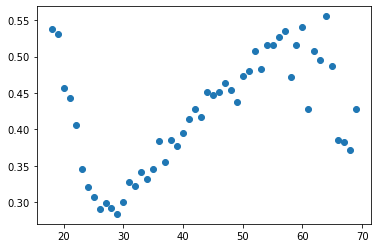

In [3]:
x = sorted(pets_dict.keys())
y = []
for num in x:
    pts = pets_dict[num]
    npts = no_pets_dict[num]
    y.append(pts/(npts + pts))
    
plt.scatter(x, y)
print("Linear Correlations:")
print(f"    Pearson Correlation: {stats.pearsonr(x, y)}")
print(f"    Spearman Correlation: {stats.spearmanr(x, y)}")
print("Interestingly the correlation seen here is almost sinusoidal")

Parameters [18.8436532  69.2658463   0.42195676]
RMSE: 0.0783722245291344
R-squared: 0.00013433672036899935


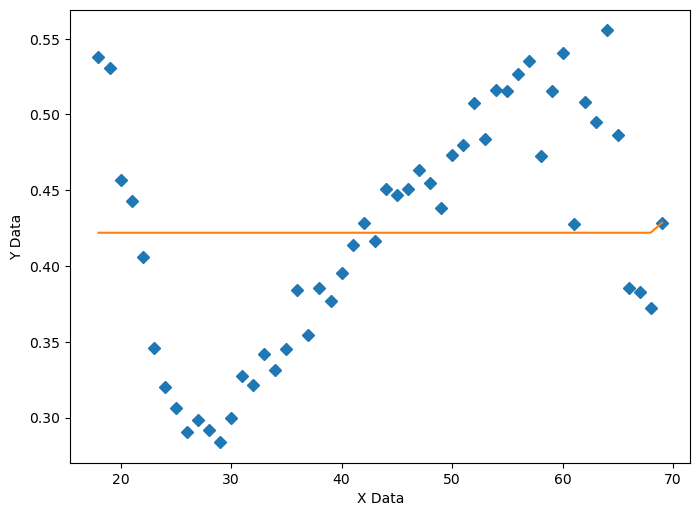

In [4]:
from scipy.optimize import curve_fit
from scipy.optimize import differential_evolution
import warnings

xData = x
yData = y

def func(x, a, b, Offset): # Sigmoid A With Offset from zunzun.com
    return  1.0 / (1.0 + numpy.exp(-a * (x-b))) + Offset


# function for genetic algorithm to minimize (sum of squared error)
def sumOfSquaredError(parameterTuple):
    warnings.filterwarnings("ignore") # do not print warnings by genetic algorithm
    val = func(xData, *parameterTuple)
    return numpy.sum((yData - val) ** 2.0)


def generate_Initial_Parameters():
    # min and max used for bounds
    maxX = max(xData)
    minX = min(xData)
    maxY = max(yData)
    minY = min(yData)

    parameterBounds = []
    parameterBounds.append([minX, maxX]) # search bounds for a
    parameterBounds.append([minX, maxX]) # search bounds for b
    parameterBounds.append([0.0, maxY]) # search bounds for Offset
    
# "seed" the numpy random number generator for repeatable results
    result = differential_evolution(sumOfSquaredError, parameterBounds, seed=3)
    return result.x

# generate initial parameter values
geneticParameters = generate_Initial_Parameters()

# curve fit the test data
fittedParameters, pcov = curve_fit(func, xData, yData, geneticParameters)

print('Parameters', fittedParameters)

modelPredictions = func(xData, *fittedParameters) 

absError = modelPredictions - yData

SE = numpy.square(absError) # squared errors
MSE = numpy.mean(SE) # mean squared errors
RMSE = numpy.sqrt(MSE) # Root Mean Squared Error, RMSE
Rsquared = 1.0 - (numpy.var(absError) / numpy.var(yData))
print('RMSE:', RMSE)
print('R-squared:', Rsquared)



##########################################################
# graphics output section
def ModelAndScatterPlot(graphWidth, graphHeight):
    f = plt.figure(figsize=(graphWidth/100.0, graphHeight/100.0), dpi=100)
    axes = f.add_subplot(111)

    # first the raw data as a scatter plot
    axes.plot(xData, yData,  'D')

    # create data for the fitted equation plot
    xModel = numpy.linspace(min(xData), max(xData))
    yModel = func(xModel, *fittedParameters)

    # now the model as a line plot 
    axes.plot(xModel, yModel)

    axes.set_xlabel('X Data') # X axis data label
    axes.set_ylabel('Y Data') # Y axis data label

    plt.show()
    plt.close('all') # clean up after using pyplot

graphWidth = 800
graphHeight = 600
ModelAndScatterPlot(graphWidth, graphHeight)